**Import the Libraries**

In [22]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import joblib

**Load Preprocessed Data**

In [23]:
data = pd.read_csv('new_data.csv')
data['week'] = pd.to_datetime(data['week'])

 **Settings**

In [4]:
TARGET = 'log1p_revenue'
TIME_COL = 'week'

**Define channels/features**






In [24]:
SOCIALS = ['facebook_spend','tiktok_spend','instagram_spend','snapchat_spend']
SEARCH = ['google_spend']
ADSTOCK = [f'{s.split("_")[0]}_adstock' for s in SEARCH + SOCIALS]
EXTRA = ['log_price','average_price','promotions','followers','email_sent','sms_sent']

**Keep only the columns that exist in the data**

In [25]:
SOCIALS = [c for c in SOCIALS if c in data.columns]
SEARCH = [c for c in SEARCH if c in data.columns]
ADSTOCK = [c for c in ADSTOCK if c in data.columns]
EXTRA = [c for c in EXTRA if c in data.columns]

**Identify lagged features and Fourier/time features**

In [26]:
lag_cols = [c for c in data.columns if '_lag' in c and any(s in c for s in SOCIALS+SEARCH+['revenue'])]
fourier_cols = [c for c in data.columns if c.startswith('annual_')]
time_feats = [c for c in ['t','week_of_year','month','year'] if c in data.columns]

**features**

In [27]:
stage1_features = SOCIALS + ADSTOCK + time_feats + fourier_cols + [c for c in EXTRA if c != 'average_price']
stage1_features = [c for c in stage1_features if c in data.columns]

stage2_features = SOCIALS + ADSTOCK + lag_cols + time_feats + fourier_cols + EXTRA
stage2_features = [c for c in stage2_features if c in data.columns]

print("Stage1 features:", stage1_features)
print("Stage2 features:", stage2_features)

Stage1 features: ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'google_adstock', 'facebook_adstock', 'tiktok_adstock', 'instagram_adstock', 'snapchat_adstock', 't', 'week_of_year', 'month', 'year', 'annual_sin_1', 'annual_cos_1', 'annual_sin_2', 'annual_cos_2', 'annual_sin_3', 'annual_cos_3', 'log_price', 'promotions']
Stage2 features: ['facebook_spend', 'tiktok_spend', 'instagram_spend', 'snapchat_spend', 'google_adstock', 'facebook_adstock', 'tiktok_adstock', 'instagram_adstock', 'snapchat_adstock', 'facebook_spend_lag1', 'facebook_spend_lag2', 'facebook_spend_lag3', 'facebook_spend_lag4', 'tiktok_spend_lag1', 'tiktok_spend_lag2', 'tiktok_spend_lag3', 'tiktok_spend_lag4', 'instagram_spend_lag1', 'instagram_spend_lag2', 'instagram_spend_lag3', 'instagram_spend_lag4', 'snapchat_spend_lag1', 'snapchat_spend_lag2', 'snapchat_spend_lag3', 'snapchat_spend_lag4', 'google_spend_lag1', 'google_spend_lag2', 'google_spend_lag3', 'google_spend_lag4', 'revenue_lag1', 're

**Train/Test Split**

In [28]:
TEST_WEEKS = 12
train = data.iloc[:-TEST_WEEKS].copy()
test  = data.iloc[-TEST_WEEKS:].copy()

**Stage1: RandomForest to predict Google spend**

In [29]:
if len(SEARCH) == 0:
    raise ValueError("No google_spend column found in data.")
google_col = SEARCH[0]

train_s1 = train.dropna(subset=stage1_features + [google_col])
X_s1 = train_s1[stage1_features]
y_s1 = train_s1[google_col]

s1_model = make_pipeline(StandardScaler(),
                         RandomForestRegressor(n_estimators=200, max_depth=6, random_state=42))
s1_model.fit(X_s1, y_s1)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=6, n_estimators=200,
                                       random_state=42))])

**Predict Google spend for entire dataset**

In [30]:
data['google_pred'] = np.nan
mask_all = data[stage1_features].notna().all(axis=1)
data.loc[mask_all, 'google_pred'] = s1_model.predict(data.loc[mask_all, stage1_features])
data['google_pred'] = data['google_pred'].fillna(0)

if 'google_pred' not in stage2_features:
    stage2_features = ['google_pred'] + [c for c in stage2_features if c != google_col]

**Stage2: GradientBoosting to predict Revenue**

In [31]:
train_s2 = data.iloc[:-TEST_WEEKS].dropna(subset=stage2_features + [TARGET]).copy()
test_s2  = data.iloc[-TEST_WEEKS:].dropna(subset=stage2_features + [TARGET]).copy()

X_train = train_s2[stage2_features]
y_train = train_s2[TARGET]
X_test  = test_s2[stage2_features]
y_test  = test_s2[TARGET]

**Evaluation function**

In [32]:
def eval_model(model, Xtr, ytr, Xte, yte):
    ytr_pred = model.predict(Xtr)
    yte_pred = model.predict(Xte)
    def metrics(y_true, y_pred):
        rmse = np.sqrt(mean_squared_error(y_true, y_pred))
        mae  = mean_absolute_error(y_true, y_pred)
        r2   = r2_score(y_true, y_pred)
        return {'rmse': rmse, 'mae': mae, 'r2': r2}
    return metrics(ytr, ytr_pred), metrics(yte, yte_pred), yte_pred

 **Fit Stage2 GradientBoosting**

In [33]:
s2_model = make_pipeline(StandardScaler(),
                         GradientBoostingRegressor(n_estimators=300, learning_rate=0.05,
                                                   max_depth=5, random_state=42))
s2_model.fit(X_train, y_train)

train_metrics, test_metrics, y_test_pred = eval_model(s2_model, X_train, y_train, X_test, y_test)
print("Train metrics:", train_metrics)
print("Test metrics:", test_metrics)

Train metrics: {'rmse': np.float64(9.398042886511012e-06), 'mae': 7.6662757824533e-06, 'r2': 0.9999999999194477}
Test metrics: {'rmse': np.float64(0.10277950540458815), 'mae': 0.0652793088767788, 'r2': 0.9756596762629197}


**Residual plot**

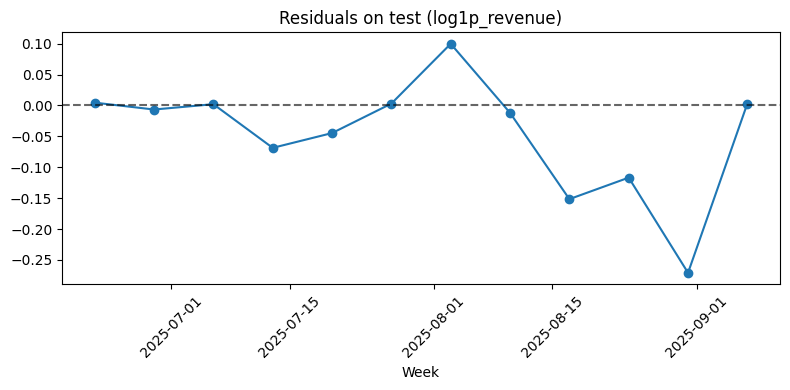

In [34]:
resid = y_test - y_test_pred
plt.figure(figsize=(8,4))
plt.plot(test_s2[TIME_COL], resid, marker='o')
plt.axhline(0, color='k', linestyle='--', alpha=0.6)
plt.title('Residuals on test (log1p_revenue)')
plt.xlabel('Week')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()



 **Google predicted vs actual**


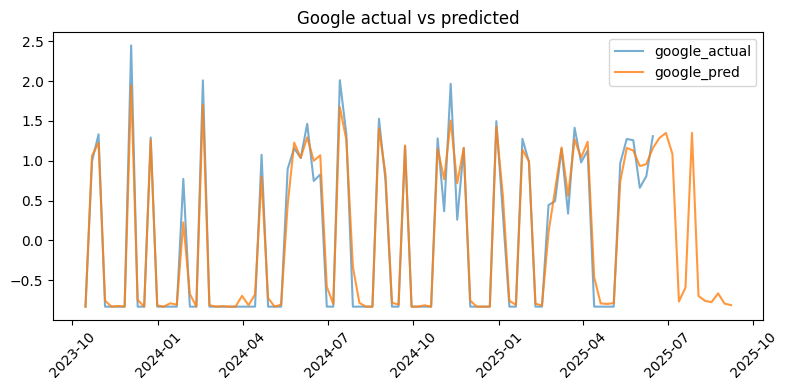

In [35]:
plt.figure(figsize=(8,4))
plt.plot(train[TIME_COL], train[google_col], label='google_actual', alpha=0.6)
plt.plot(data[TIME_COL], data['google_pred'], label='google_pred', alpha=0.8)
plt.legend()
plt.title('Google actual vs predicted')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

**Feature importances**

In [36]:
importances = s2_model.named_steps['gradientboostingregressor'].feature_importances_
fi = pd.DataFrame({'feature': stage2_features, 'importance': importances}).sort_values('importance', ascending=False)
print("\nTop Stage2 features:")
print(fi.head(15))


Top Stage2 features:
                feature  importance
3       instagram_spend    0.500979
45        average_price    0.277626
44            log_price    0.204495
40         annual_sin_2    0.004289
43         annual_cos_3    0.003532
12  facebook_spend_lag3    0.002738
10  facebook_spend_lag1    0.001301
0           google_pred    0.000680
30         revenue_lag1    0.000678
16    tiktok_spend_lag3    0.000621
1        facebook_spend    0.000387
42         annual_sin_3    0.000235
13  facebook_spend_lag4    0.000197
32         revenue_lag3    0.000163
26    google_spend_lag1    0.000154


***Save models***

In [37]:
joblib.dump(s1_model, 'stage1_google_rf.pkl')
joblib.dump(s2_model, 'stage2_revenue_gb.pkl')

['stage2_revenue_gb.pkl']

In [38]:
print("\nNotes:")
print("- Stage1: RandomForest predicts Google spend (mediator).")
print("- Stage2: GradientBoosting predicts revenue using predicted Google + socials + adstock + lags + controls.")
print("- Tree models handle nonlinearity and interactions better than linear models.")


Notes:
- Stage1: RandomForest predicts Google spend (mediator).
- Stage2: GradientBoosting predicts revenue using predicted Google + socials + adstock + lags + controls.
- Tree models handle nonlinearity and interactions better than linear models.
